# Recreating the client configurations

In [4]:
# Imports

import scienceplots
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from client.client import FlowerClient

In [5]:
# Set up font and text rendering for matplotlib outputs
plt.style.use(["science", "ieee"])
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

## Generate deployment client configurations

In [81]:
# Define deployment client configurations paths and seeds
# deployment_clients = [
#     ("logs/clients/clients25_1001.json", 1001),
#     ("logs/clients/clients25_1002.json", 1002),
#     ("logs/clients/clients25_1003.json", 1003),
#     ("logs/clients/clients25_1004.json", 1004),
#     ("logs/clients/clients25_1005.json", 1005),
# ]

deployment_clients = [
    ("logs/clients/clients20_1001.json", 1001),
    ("logs/clients/clients20_1002.json", 1002),
    ("logs/clients/clients20_1003.json", 1003),
    ("logs/clients/clients20_1004.json", 1004),
    ("logs/clients/clients20_1005.json", 1005),
]

In [83]:
# Generate client configurations
for path, seed in deployment_clients:
    FlowerClient.generate_deployment_clients(20, path, seed=seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [35]:
# Read the client configurations
idxss, batch_sizess, local_epochss, data_volumess, data_labelss = [], [], [], [], []
for client_path, _ in deployment_clients:
    idxs, batch_sizes, local_epochs, data_volumes, data_labels = FlowerClient.read_many(client_path)
    idxss.append(idxs)
    batch_sizess.append(batch_sizes)
    local_epochss.append(local_epochs)
    data_volumess.append(data_volumes)
    data_labelss.append(data_labels)

# Visualize batch size and local epoch distribution
For 5 client configurations generated using seeds 1001 to 1005 (see above)

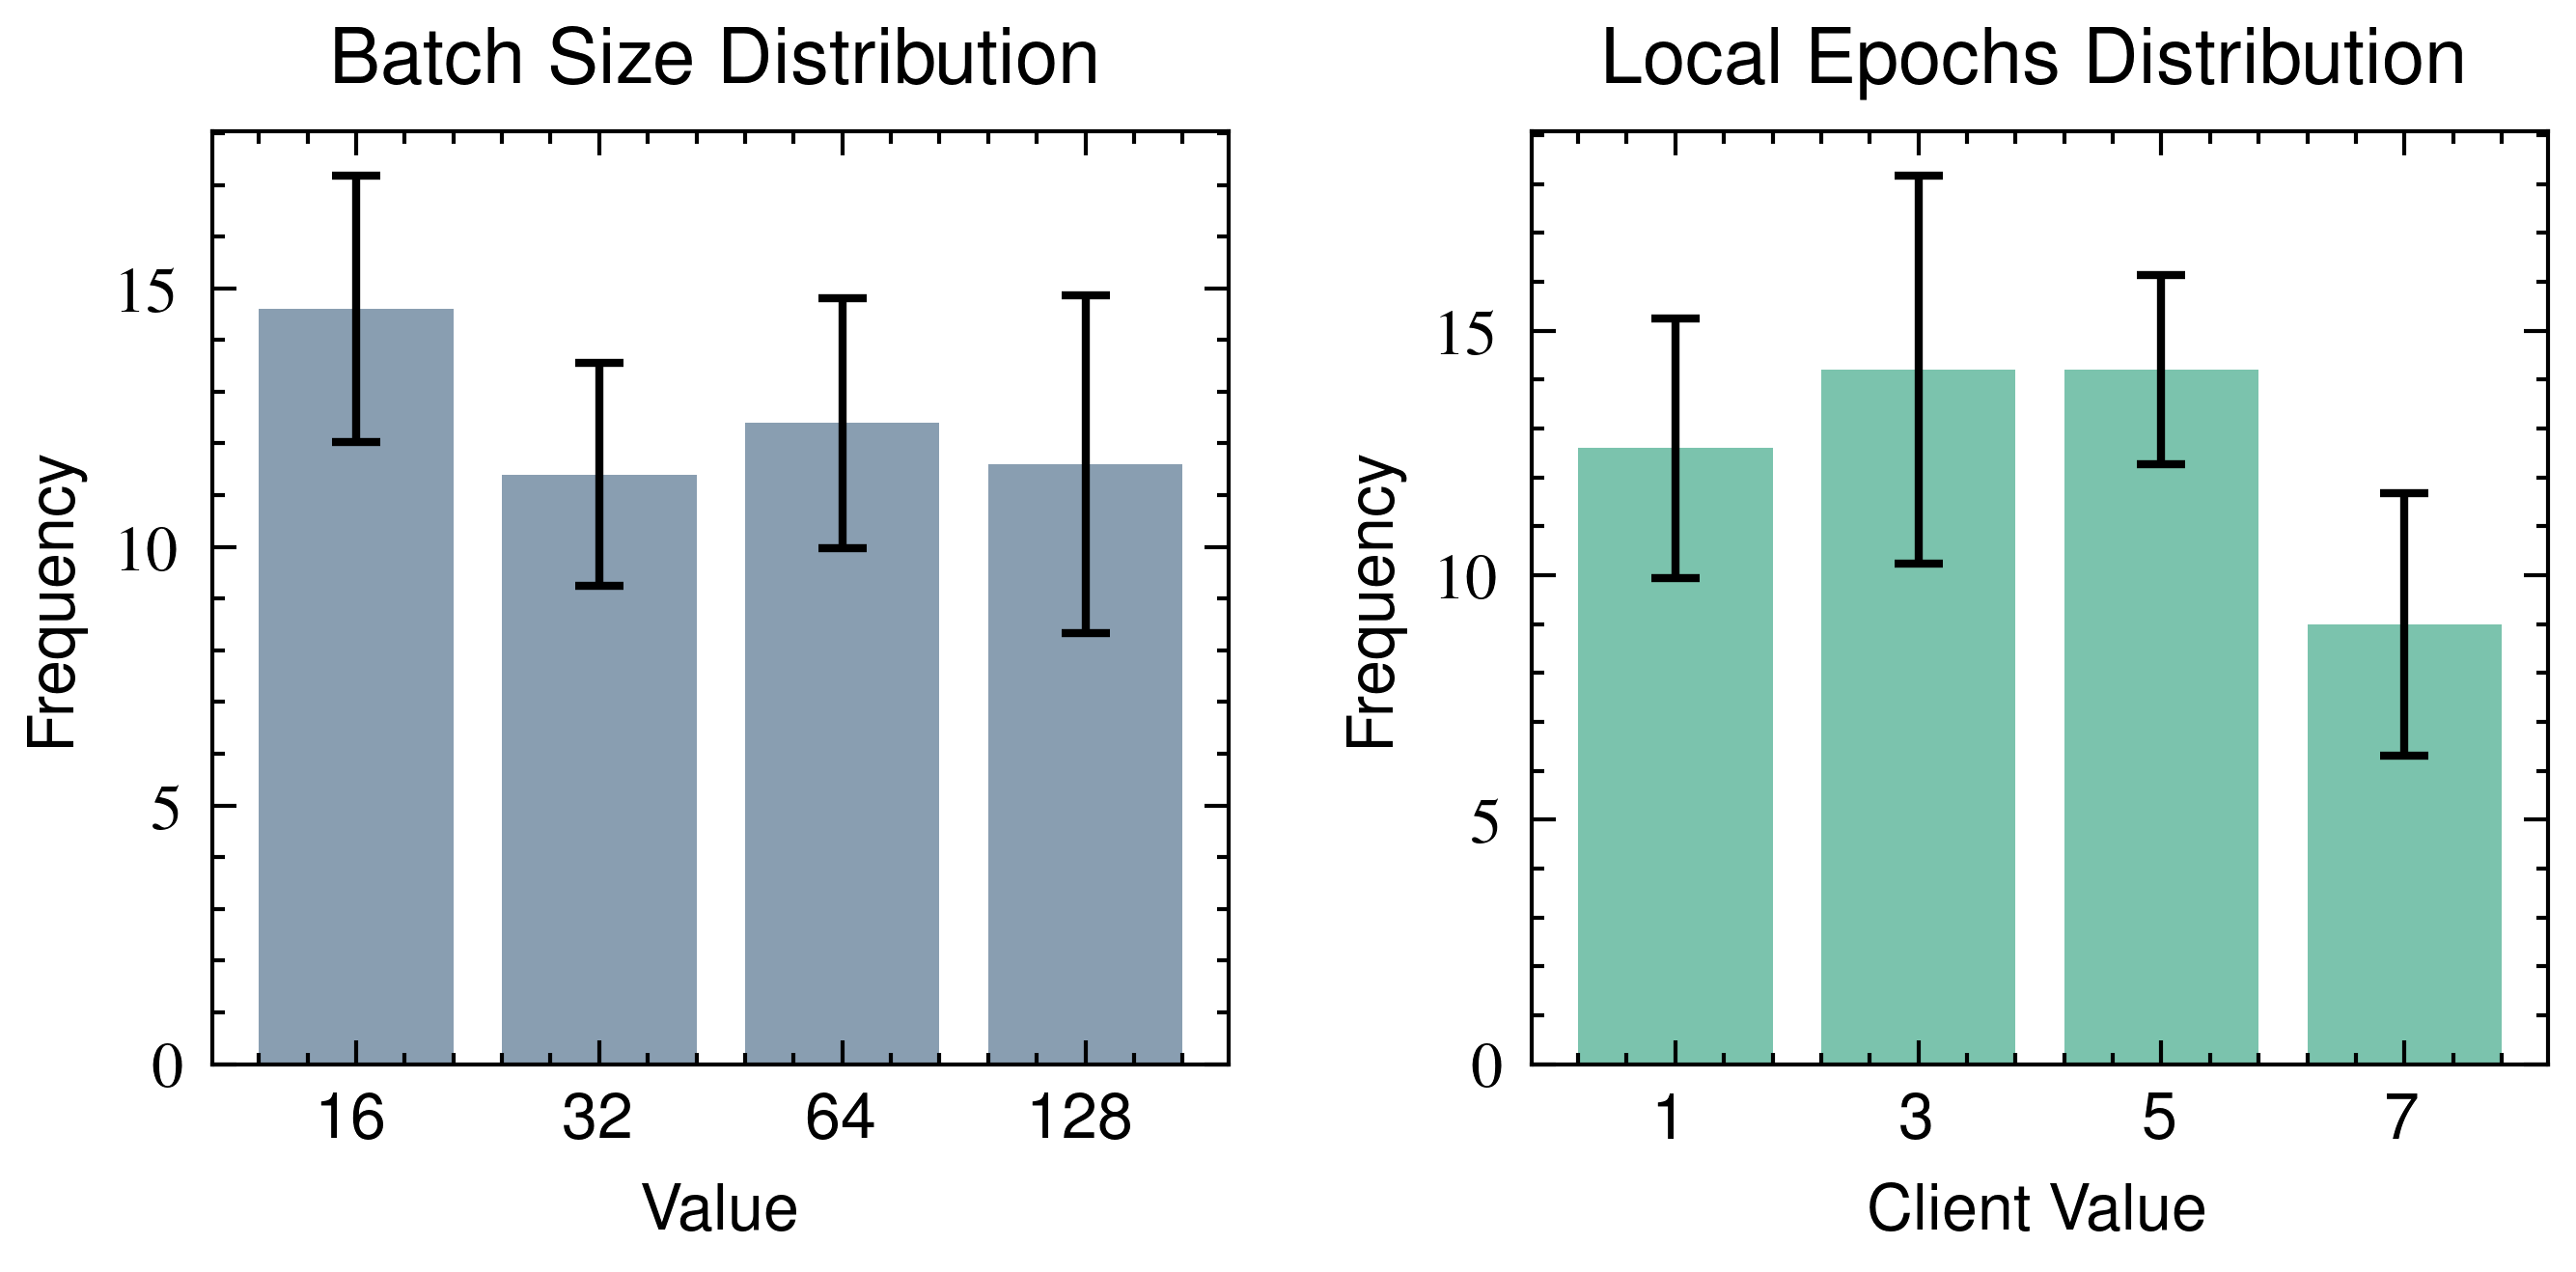

In [26]:
# Calculate frequencies
batch_values_and_counts = [np.unique(batch_sizes, return_counts=True) for batch_sizes in batch_sizess]
epoch_values_and_counts = [np.unique(local_epochs, return_counts=True) for local_epochs in local_epochss]

batch_values = [str(val) for val in batch_values_and_counts[0][0]]
batch_means = np.mean([counts for _, counts in batch_values_and_counts], axis=0)
batch_stddev = np.std([counts for _, counts in batch_values_and_counts], axis=0)
# batch_counts = [counts for _, counts in batch_values_and_counts]

epoch_values = [str(val) for val in epoch_values_and_counts[0][0]]
epoch_means = np.mean([counts for _, counts in epoch_values_and_counts], axis=0)
epoch_stddev = np.std([counts for _, counts in epoch_values_and_counts], axis=0)
# epoch_counts = [counts for _, counts in epoch_values_and_counts]

# Set up font and text rendering
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# Create 2 bar charts from the data volumes and data labels
fig, ax = plt.subplots(1, 2, figsize=(505/72/1.5, 505/72/3))

# Bar chart for array1
ax[0].bar(batch_values, batch_means, color='#577590', alpha=0.7, yerr=batch_stddev, capsize=3)
ax[0].set_title("Batch Size Distribution")
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Frequency")

# Bar chart for array2
ax[1].bar(epoch_values, epoch_means, color='#43AA8B', alpha=0.7, yerr=epoch_stddev, capsize=3)
ax[1].set_title("Local Epochs Distribution")
ax[1].set_xlabel("Client Value")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig('for-report/fig_client.pdf')
plt.show()

# Visualize data volume and data label distribution
For 5 client configurations generated using seeds 1001 to 1005 (see above)

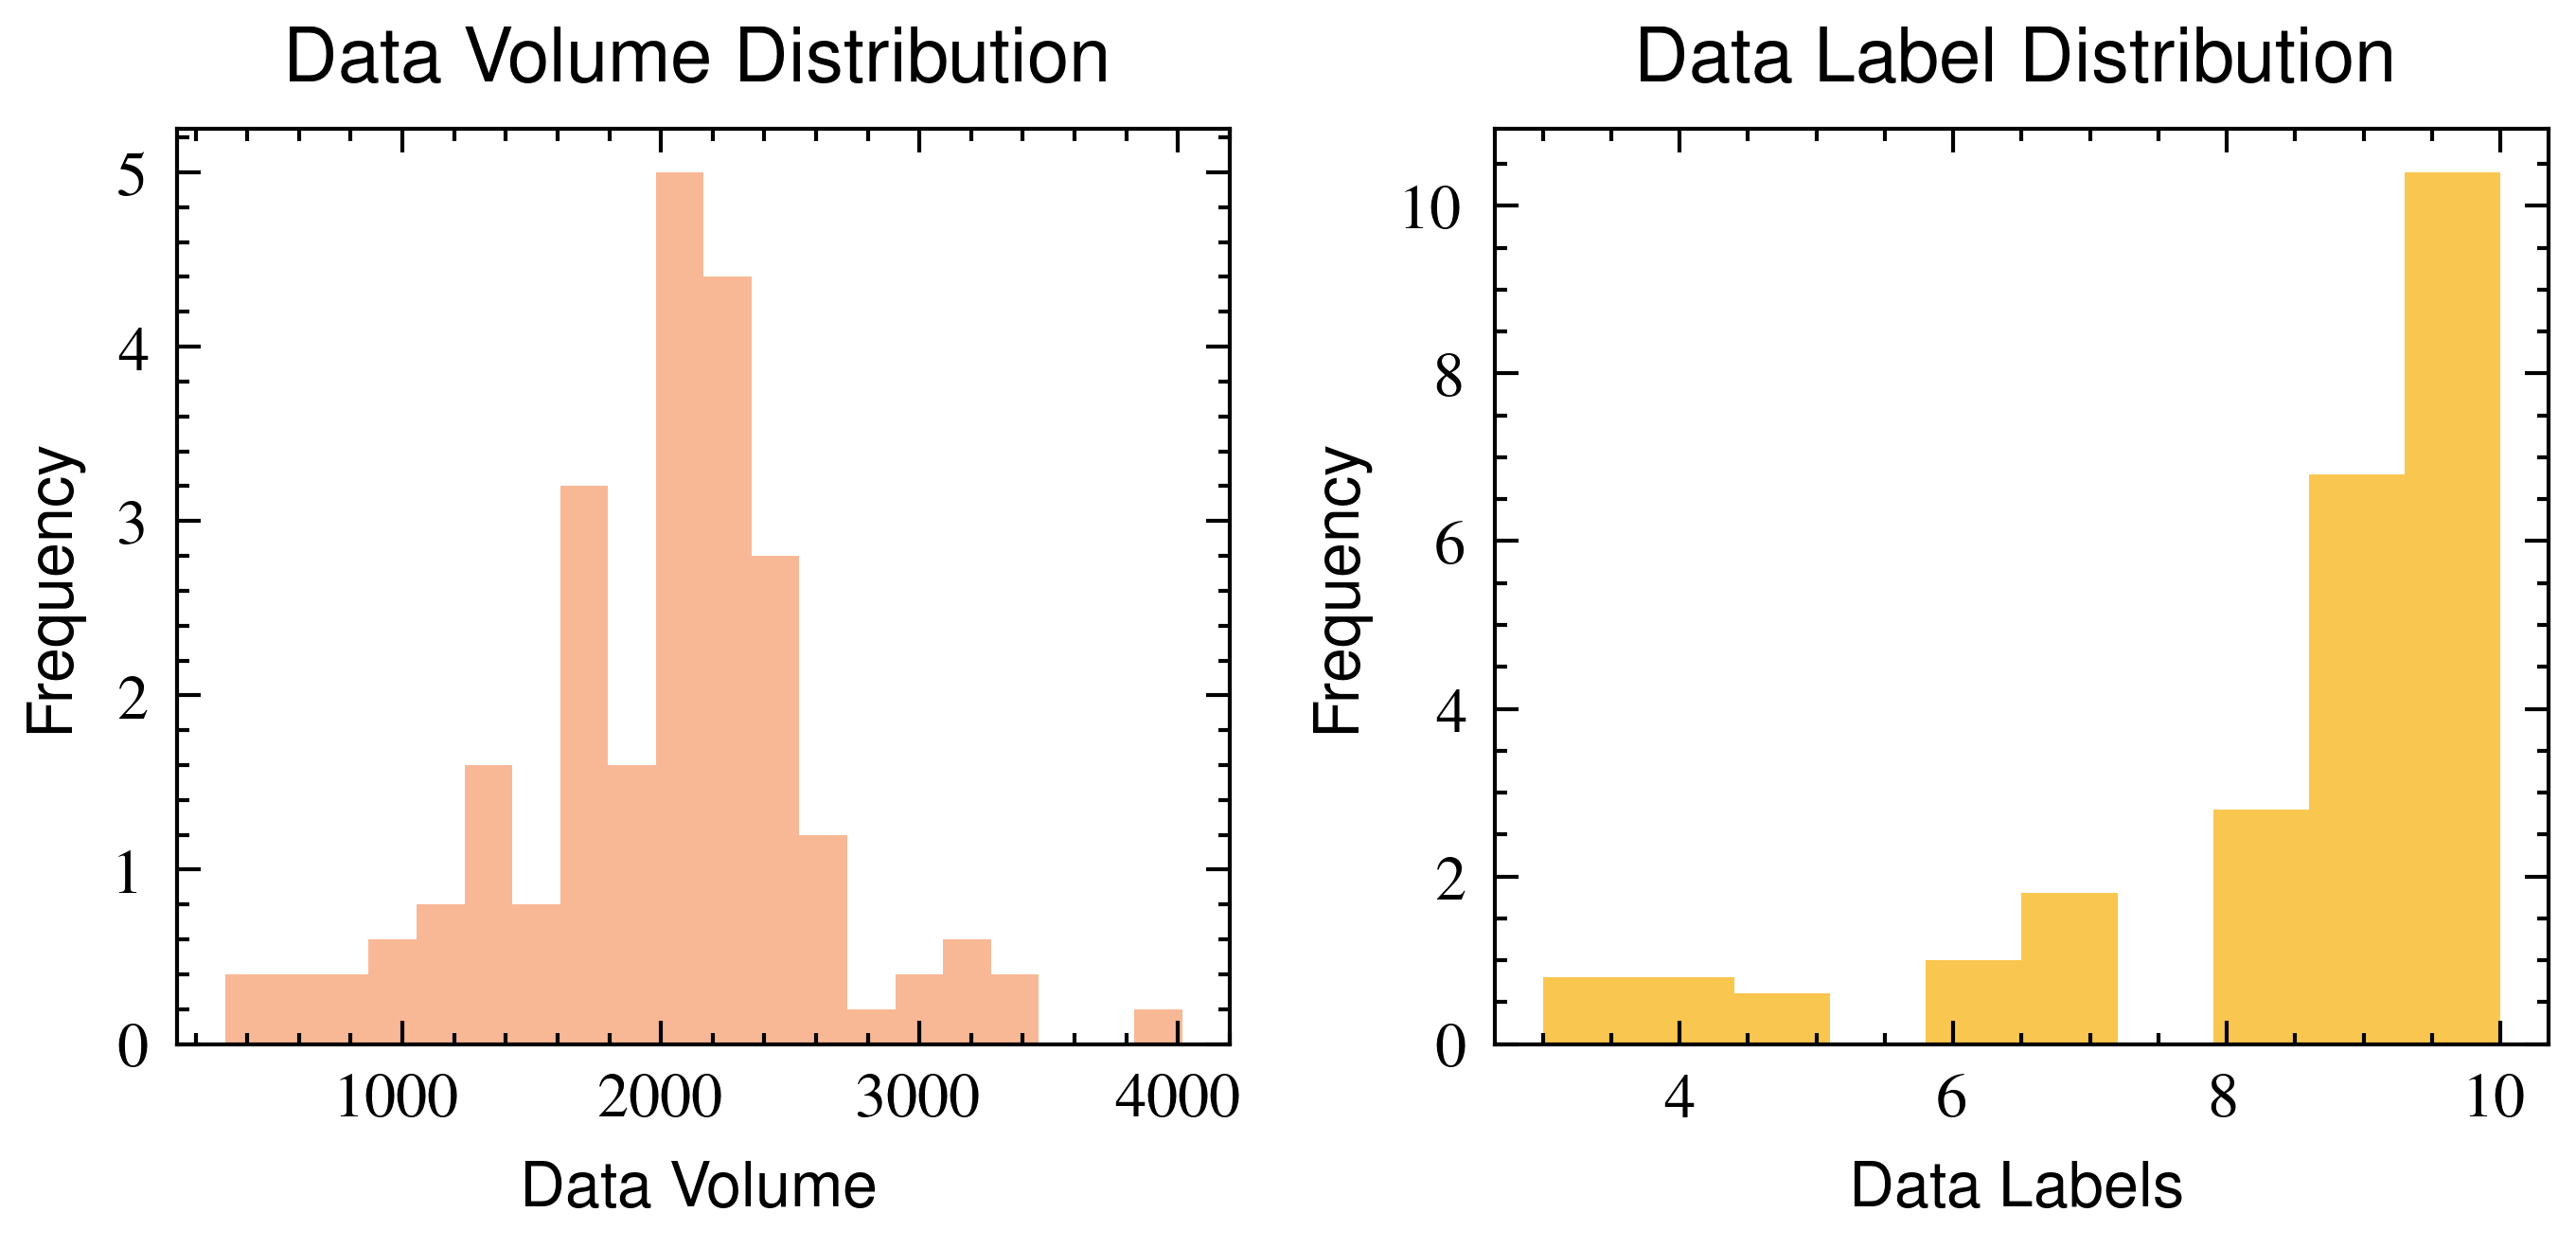

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(505/72/1.5, 505/72/3))
data_volumes = np.concatenate(data_volumess)
ax[0].hist(data_volumes, bins=20, alpha=0.5, color="#F3722C", weights=np.ones_like(data_volumes) / len(data_volumess))
ax[0].set_title("Data Volume Distribution")
ax[0].set_xlabel("Data Volume")
ax[0].set_ylabel("Frequency")

data_labels = np.concatenate(data_labelss)
ax[1].hist(data_labels, bins=10, color="#F9C74F", weights=np.ones_like(data_labels) / len(data_volumess))
ax[1].set_title("Data Label Distribution")
ax[1].set_xlabel("Data Labels")
ax[1].set_ylabel("Frequency")

plt.tight_layout()

plt.savefig(f'for-report/fig_data.pdf')
plt.show()

# Visualize results

In [6]:
from collections import defaultdict
from visualization.data import RunData

# Define runs to visualize
all_runs = [f"run_{i}" for i in range(565, 595)]
all_runs.append("run_360")
# all_runs = [f"run_{i}" for i in range(535, 565)]
all_runs = RunData.build_many(all_runs, base_path="from-hertz/logs")

# Group runs by code to average
runs_by_code = defaultdict(list)
for run in all_runs:
    runs_by_code[run.run_config.code].append(run)
runs_by_code = dict(runs_by_code)

# runs_by_code = {key: runs[:1] for key, runs in runs_by_code.items()}

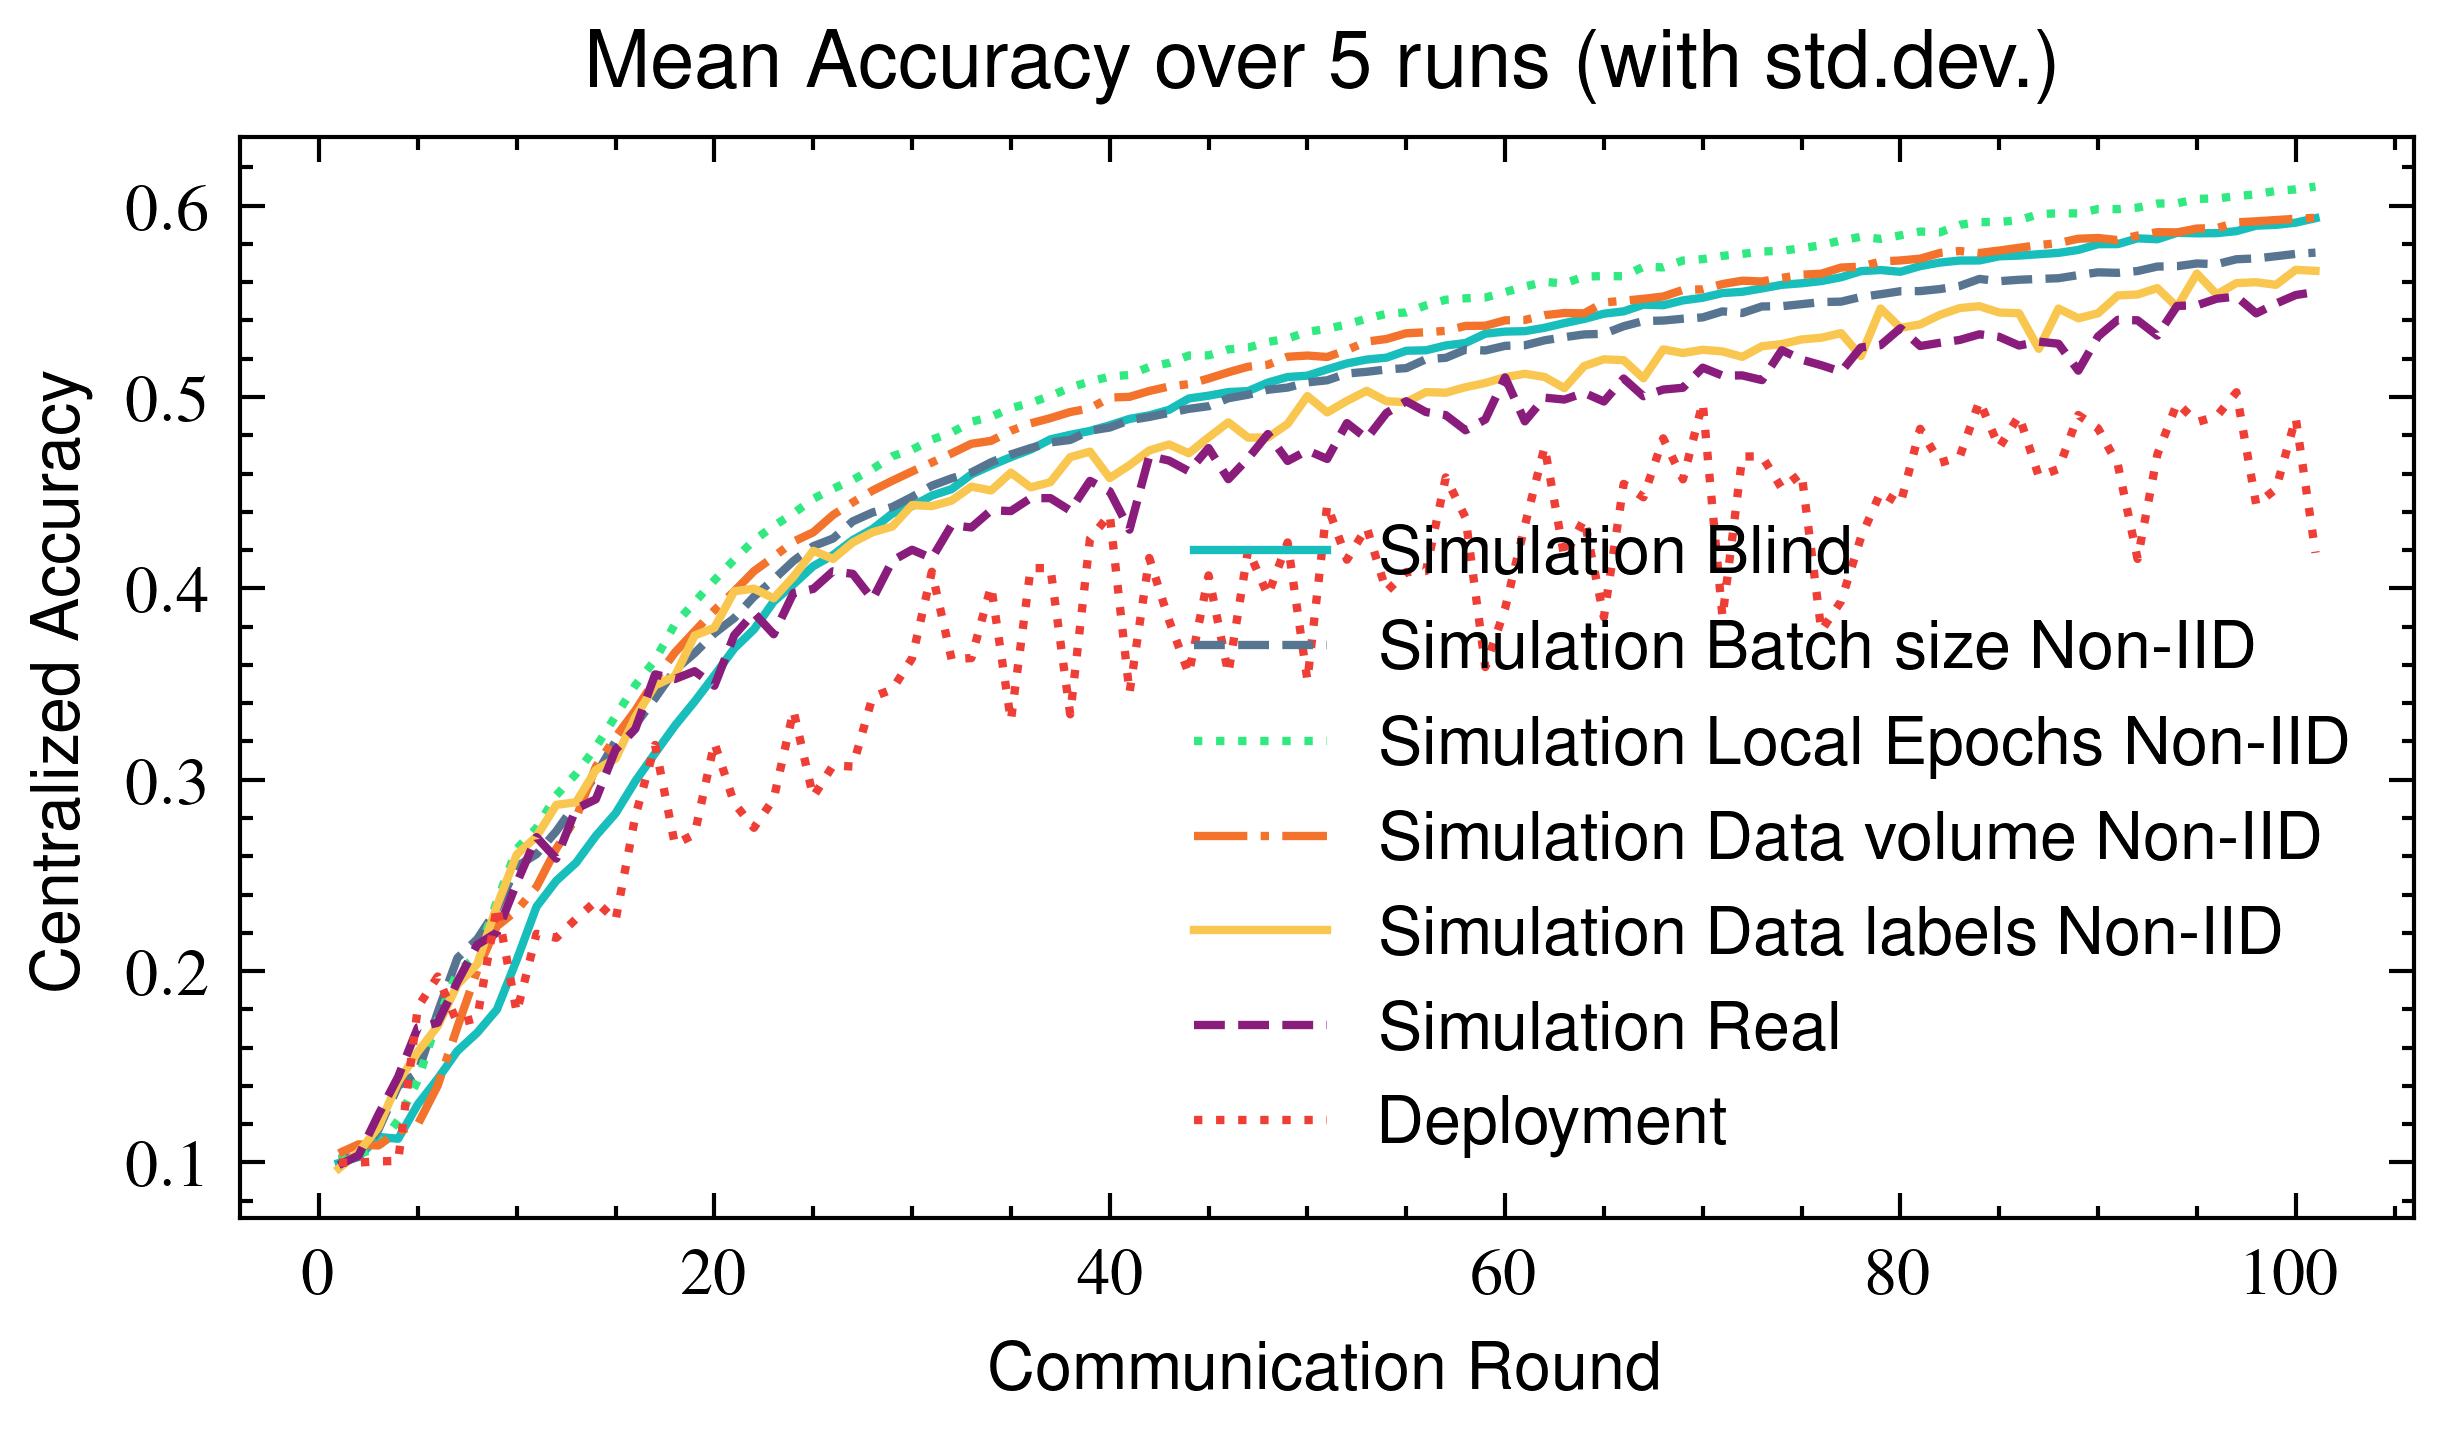

In [12]:
# Plot the accuracy of the runs

def adjust_lightness(color, amount=0.5):
    # Utility function to plot error boundaries of same lighter color
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

plt.figure(figsize=(505/72/1.5, 505/72/3))

for code, runs in runs_by_code.items():
    run_accuracy = [np.array(run.get_metric("accuracy").y) for run in runs]
    mean = np.mean(run_accuracy, axis=0)
    std_dev = np.std(run_accuracy, axis=0)

    upper_bound = mean + std_dev
    lower_bound = mean - std_dev
    
    style = runs[0].get_metric("accuracy").style

    xs = np.arange(1, len(mean) + 1)
    plt.plot(xs, mean, label=runs[0].run_config.get_label(), color=style.color)
    # plt.fill_between(xs, lower_bound, upper_bound, color=adjust_lightness(style.color), alpha=0.1)
    
plt.xlabel('Communication Round')
plt.ylabel('Centralized Accuracy')
plt.title('Mean Accuracy over 5 runs (with std.dev.)')
plt.legend()
plt.show()

# Visualize the correlation between runs

In [10]:
import itertools
from visualization.utils import (
    calculate_mae,
    calculate_mse,
    calculate_dtw,
    calculate_pearson_correlation,
)


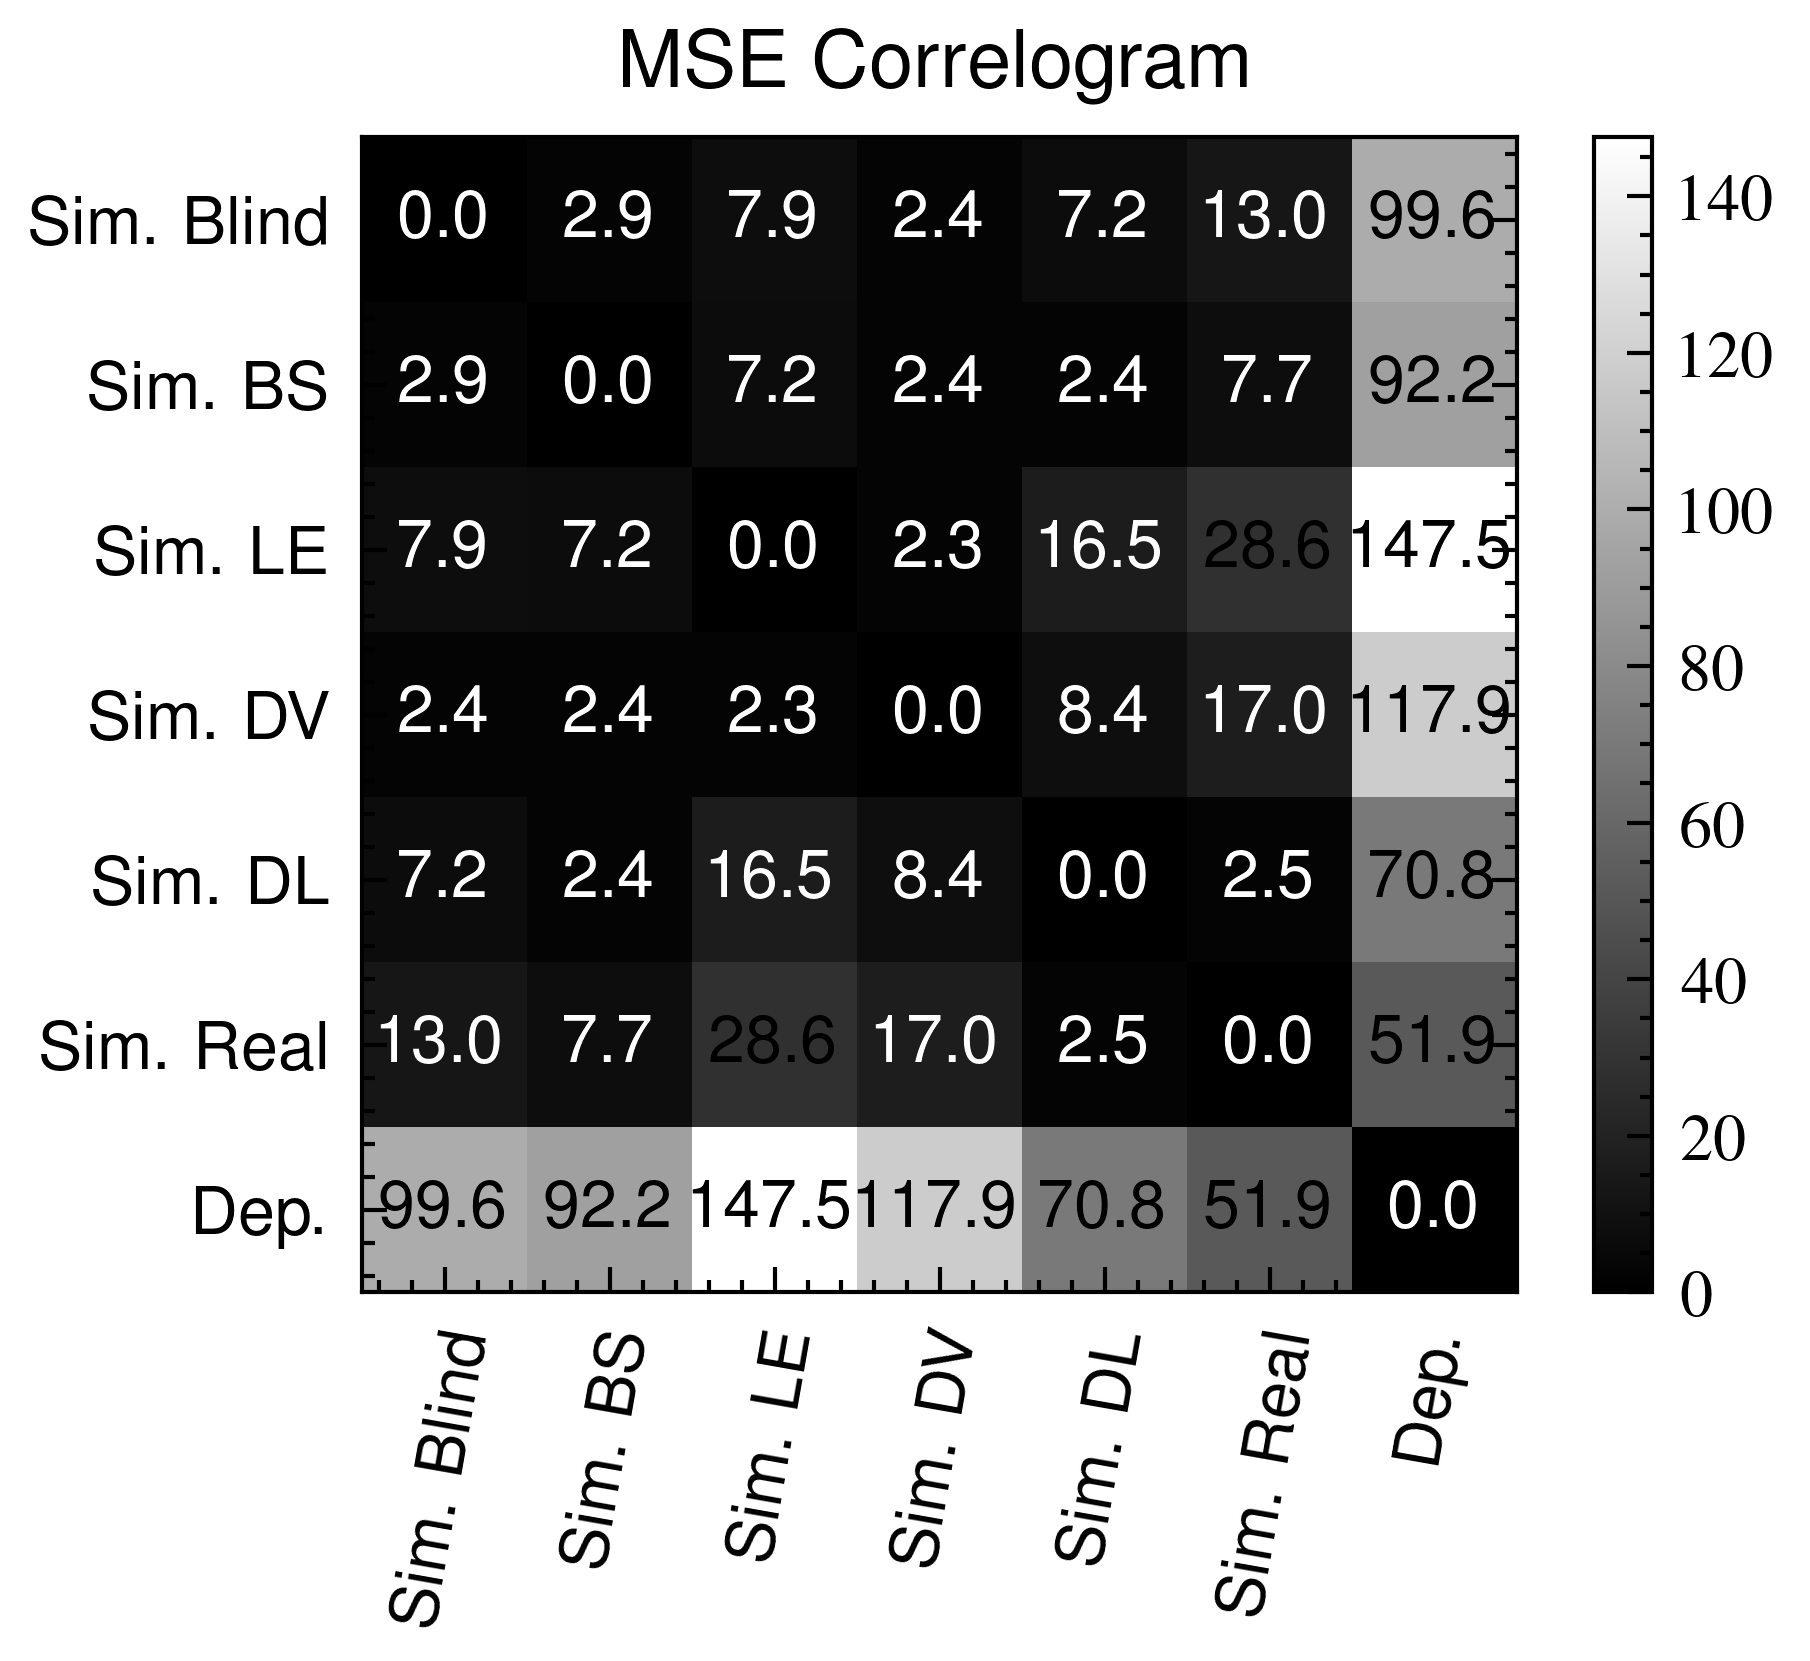

In [11]:
accuracies = [100 * np.mean([np.array(run.get_metric("accuracy").y) for run in runs], axis=0) for code, runs in runs_by_code.items()]
num_arrays = len(runs_by_code)
matrix = np.zeros((num_arrays, num_arrays))

for i, j in itertools.combinations(range(num_arrays), 2):
    mse = calculate_mse(accuracies[i], accuracies[j])
    matrix[i, j] = mse
    matrix[j, i] = mse

fig, ax = plt.subplots()
cax = ax.matshow(matrix, cmap="gist_gray", interpolation="none")
fig.colorbar(cax)

avg = np.average(matrix)

for (i, j), z in np.ndenumerate(matrix):
    ax.text(
        j,
        i,
        "{:0.1f}".format(z),
        ha="center",
        va="center",
        color="white" if z < avg / 1.5 else "black",
    )

# Set ticks and labels
ax.set_xticks(range(num_arrays))
ax.set_yticks(range(num_arrays))
labels = [run[0].run_config.get_label(short=True) for run in runs_by_code.values()]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.tick_params(axis="x", labelrotation=80)
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

plt.title("MSE Correlogram")
plt.show()

# Output CSV files for results

In [103]:
with open("logs/accuracies.csv", "w") as file:
    file.write("Config,Accuracy,Loss\n")
    for code, runs in runs_by_code.items():
        run_accuracy = [100 * np.array(run.get_metric("accuracy").y) for run in runs]
        max_accs = [np.max(run) for run in run_accuracy]
        std_acc = np.std(max_accs)
        mean_acc = np.mean(max_accs)
        
        run_loss = [np.array(run.get_metric("loss").y) for run in runs]
        min_losses = [np.min(run) for run in run_loss]
        mean_loss = np.mean(min_losses)
        std_loss = np.std(min_losses)
        
        data = [
            runs[0].run_config.get_label(short=True),
            f"{np.max(mean_acc):.2f} ± {std_acc:.2f}",
            # std_acc,
            f"{np.max(mean_loss):.2f} ± {std_loss:.2f}"
            # np.max(mean_loss),
            # std_loss
        ]
        
        file.write(",".join(data) + "\n")

# Algorithm for replicating clients

In [ ]:
"""
SEED = 42
DATASET = "cifar10"
NUM_CLIENTS = 50

def replicate_clients(
    datapoints_per_client: List[int],
    labels_per_client: List[int],
):
    prng = np.random.default_rng(SEED)

    label_indices = {
        k: np.where(DATASET.targets == k)[0].tolist() for k in range(DATASET.classes)
    }
    for indices in label_indices.values():
        prng.shuffle(indices)

    idx_clients: List[List[int]] = [[] for _ in range(NUM_CLIENTS)]

    for client_id, (num_samples, num_labels) in enumerate(
        zip(datapoints_per_client, labels_per_client)
    ):
        selected_labels = prng.choice(range(DATASET.classes), num_labels, replace=False)
        client_indices = []

        for label in selected_labels:
            count_needed = (num_samples // num_labels) + (
                1 if num_samples % num_labels > 0 else 0
            )
            count_assigned = 0

            while label_indices[label] and count_assigned < count_needed:
                client_indices.append(label_indices[label].pop())
                count_assigned += 1

        prng.shuffle(client_indices)
        idx_clients[client_id] = client_indices[:num_samples]

    remaining_indices = [idx for indices in label_indices.values() for idx in indices]
    prng.shuffle(remaining_indices)

    for client_id in range(NUM_CLIENTS):
        if len(idx_clients[client_id]) < datapoints_per_client[client_id]:
            required = datapoints_per_client[client_id] - len(idx_clients[client_id])
            idx_clients[client_id].extend(remaining_indices[:required])
            remaining_indices = remaining_indices[required:]

    return idx_clients
"""